Code by Jonas

In [12]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt
import os

In [2]:
#read in the data
path_bindingAffinity = '/Users/jones/coding/Princeton_Homework/QCB455_Comp/project/551-project-main/data/binding_affinity/binding_info.csv'
df_bindingAffinity = pd.read_csv(path_bindingAffinity)

pathShannon = '/Users/jones/coding/Princeton_Homework/QCB455_Comp/project/551-project-main/data/entropy/manual/Shannon.csv'
df_Shannon = pd.read_csv(pathShannon)
pathAllel = '/Users/jones/coding/Princeton_Homework/QCB455_Comp/project/551-project-main/data/NetMHCpan/alleles.csv'
df_allel = pd.read_csv(pathAllel)

pathPeptide = '/Users/jones/coding/Princeton_Homework/QCB455_Comp/project/551-project-main/data/NetMHCpan/peptides.csv'
df_peptide = pd.read_csv(pathPeptide)

pathrank = '/Users/jones/coding/Princeton_Homework/QCB455_Comp/project/551-project-main/data/NetMHCpan/rank_EL_matrix.csv'
df_rank = pd.read_csv(pathrank, header=None)
df_rank.columns = df_allel['allele'].values

df_rank.index = df_peptide['peptide'].values

pathscore = '/Users/jones/coding/Princeton_Homework/QCB455_Comp/project/551-project-main/data/NetMHCpan/score_EL_matrix.csv'
df_score = pd.read_csv(pathscore, header=None)
df_score.columns = df_allel['allele'].values
df_score.index = df_peptide['peptide'].values

pathKl = '/Users/jones/coding/Princeton_Homework/QCB455_Comp/project/551-project-main/data/entropy/HIV_db/before_filtering/Entropy_One/entropy.csv'
df_Kl = pd.read_csv(pathKl)

pathKlFilt = '/Users/jones/coding/Princeton_Homework/QCB455_Comp/project/551-project-main/data/entropy/HIV_db/after_filtering/Entropy-One/entropy.csv'
df_KlFilt = pd.read_csv(pathKlFilt)


savePath = "/Users/jones/coding/Princeton_Homework/QCB455_Comp/project/551-project-main/data/linearRegression"

In [3]:
#flip the rank matrix -> higher MHC binding between peptide and allele leads to higher score
dfAnalysis = df_rank.copy()
maxVal= dfAnalysis.max().max()
minVal = dfAnalysis.min().min()
dfAnalysisNew = maxVal + minVal - dfAnalysis


In [4]:
#calculate the weighted sum 
#using maximum of the allele frequency
allelScore = df_allel.iloc[:, -6:-1].max(axis=1)
dfSum = dfAnalysisNew
dfSum.columns = allelScore
dfSum.index = df_peptide['freq']
weighted_rowSum = (dfSum * dfSum.index.values.reshape(-1, 1) * dfSum.columns.values).sum(axis=1)

weighted_rowSum.index = (df_peptide['pos'] +1)
weighted_rowSum = weighted_rowSum.groupby(weighted_rowSum.index).sum()

In [6]:
# rename KL divergence df to match column name in Shannon entropy df
df_Kl.rename(columns={'Position': 'pos'}, inplace=True)


In [7]:
#extract for each peptide the position with the highest Shannon entropy and highest binding affinity

maxEntropyList = []
maxBindingAffinityList = []



for i in range(len(weighted_rowSum)):
    start = i
    end = start +9
    df_help = df_Kl[df_Kl['pos'].isin(np.arange(start, end))]
    maxEntValue = df_help['Entropy'].max()
    bindingMax = df_bindingAffinity.loc[df_bindingAffinity['seq_position'].isin(df_help[df_help['Entropy'] == maxEntValue]['pos'].values)]['value'].max()
    maxBindingAffinityList.append(bindingMax)
    maxEntropyList.append(maxEntValue)

dfMaxEntropy = pd.DataFrame({'pos': np.arange(1, 1266), 'EntropyMax':  maxEntropyList, 'maxBinding': maxBindingAffinityList})

In [8]:
#Create X & Y variables for linear regression

Y = dfMaxEntropy['EntropyMax'].values
X = np.column_stack((weighted_rowSum.values, dfMaxEntropy['maxBinding'].values))

Text(0, 0.5, 'KL divergence')

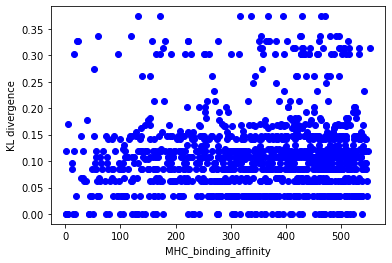

In [9]:
#visualizing input and output data

plt.scatter(weighted_rowSum.values, Y, color='blue', marker='o')
plt.xlabel('MHC_binding_affinity')
plt.ylabel('KL divergence')

In [13]:
#fit linear model
model = LinearRegression()
model.fit(X, Y)

# predict model

y_pred = model.predict(X)
all = pd.DataFrame({'test': Y, 'pred': y_pred})

In [14]:
correlation_coefficient = np.corrcoef(Y, y_pred)[0, 1]

print("Correlation Coefficient:", correlation_coefficient)

Correlation Coefficient: 0.07961877256164164


Text(0, 0.5, 'KL divergence predicted')

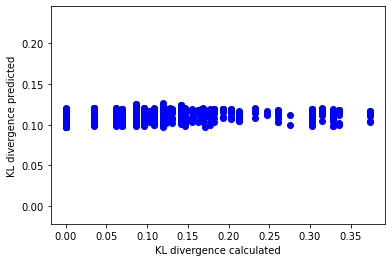

In [15]:
plt.scatter(Y, y_pred, color='blue', marker='o')
plt.axis('equal')
plt.xlabel('KL divergence calculated')
plt.ylabel('KL divergence predicted')

Shannon entropy

In [16]:
#extract highest entropy of each peptide

maxEntropyList = []
maxBindingAffinityList = []

for i in range(len(weighted_rowSum)):
    start = i
    end = start +9
    df_help = df_Shannon[df_Shannon['pos'].isin(np.arange(start, end))]
    maxEntValue = df_help['Shannon'].max()
    bindingMax = df_bindingAffinity.loc[df_bindingAffinity['seq_position'].isin(df_help[df_help['Shannon'] == maxEntValue]['pos'].values)]['value'].max()
    maxBindingAffinityList.append(bindingMax)
    maxEntropyList.append(maxEntValue)

dfMaxEntropy = pd.DataFrame({'pos': np.arange(1, 1266), 'EntropyMax':  maxEntropyList, 'maxBinding': maxBindingAffinityList})

In [19]:
#define X and Y for linear model
Y= dfMaxEntropy['EntropyMax'].values
X = np.column_stack((weighted_rowSum.values, dfMaxEntropy['maxBinding'].values))

Text(0, 0.5, 'Shannon entropy')

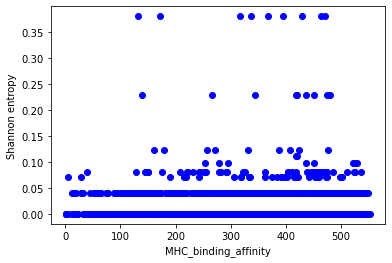

In [20]:
plt.scatter(weighted_rowSum.values, Y, color='blue', marker='o')
plt.xlabel('MHC_binding_affinity')
plt.ylabel('Shannon entropy')

In [21]:
#fit a linear model
model = LinearRegression()
model.fit(X, Y)
y_pred = model.predict(X)
all = pd.DataFrame({'test': Y, 'pred': y_pred})
correlation_coefficient = np.corrcoef(Y, y_pred)[0, 1]

print("Correlation Coefficient:", correlation_coefficient)

Correlation Coefficient: 0.034078668002613485


Text(0, 0.5, 'Shannon predicted')

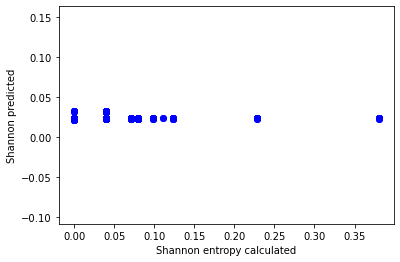

In [22]:
plt.scatter(Y, y_pred, color='blue', marker='o')
plt.axis('equal')
plt.xlabel('Shannon entropy calculated')
plt.ylabel('Shannon predicted')

Handling imbalanced Shanon entropy

In [23]:
np.unique(dfMaxEntropy['EntropyMax'], return_counts=True)

(array([0.        , 0.04004863, 0.04027237, 0.07081055, 0.08005252,
        0.09803911, 0.1107694 , 0.122957  , 0.22830987, 0.38000069]),
 array([731, 415,  13,  28,  40,   9,   2,   9,   9,   9]))

In [25]:
#split data into zero and nonzero shannon entropy

shannonZero = dfMaxEntropy.loc[dfMaxEntropy['EntropyMax'] <= 0.04004863]
shannonNonZero = dfMaxEntropy.loc[dfMaxEntropy['EntropyMax'] > 0.04004863]

In [27]:
#Using all non-zero positions for training

nonZeroPositions = shannonNonZero['pos'].values
weighted_rowSum_NonZero = weighted_rowSum[weighted_rowSum.index.isin(nonZeroPositions)]

#select a random subset of zero shannon entropy values of length non-zerp values
randomZeroShannon = np.random.choice(shannonZero['pos'].values, len(shannonNonZero), replace=False)
shannonZeroRandom = shannonZero.loc[shannonZero['pos'].isin(randomZeroShannon)]
weighted_rowSum_ZeroRandom = weighted_rowSum[weighted_rowSum.index.isin(randomZeroShannon)]

In [28]:
#define train dataset and predict on full dataset

Y_train = np.append(shannonNonZero['EntropyMax'].values, shannonZeroRandom['EntropyMax'].values)
X = np.column_stack((weighted_rowSum.values, dfMaxEntropy['maxBinding'].values))
Y = dfMaxEntropy['EntropyMax'].values
X_train = np.column_stack((np.append(weighted_rowSum_NonZero.values,weighted_rowSum_ZeroRandom.values) , 
                           np.append(shannonNonZero['maxBinding'].values, shannonZeroRandom['maxBinding'].values )))
model = LinearRegression()
model.fit(X_train, Y_train)
y_pred = model.predict(X)
all = pd.DataFrame({'test': Y, 'pred': y_pred})
correlation_coefficient = np.corrcoef(Y, y_pred)[0, 1]

print("Correlation Coefficient:", correlation_coefficient)

Correlation Coefficient: -0.03380860078166926


Text(0, 0.5, 'Shannon predicted')

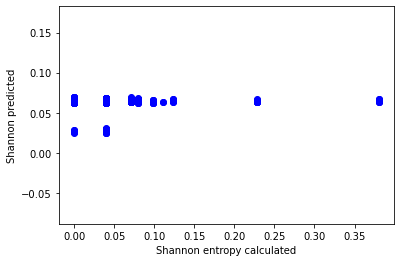

In [29]:
plt.scatter(Y, y_pred, color='blue', marker='o')
plt.axis('equal')
plt.xlabel('Shannon entropy calculated')
plt.ylabel('Shannon predicted')